In [1]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_curve,
    roc_auc_score,
    precision_recall_curve,
    average_precision_score,
    confusion_matrix,
    classification_report
)

In [2]:
data = fetch_openml(name='credit-g', version=1, as_frame=True)
df = data.frame

X = df.drop('class', axis=1)
y = df['class'].map({'good': 0, 'bad': 1})

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [3]:
best_model = joblib.load("best_credit_model.pkl")

In [4]:
y_probs = best_model.predict_proba(X_test)[:, 1]

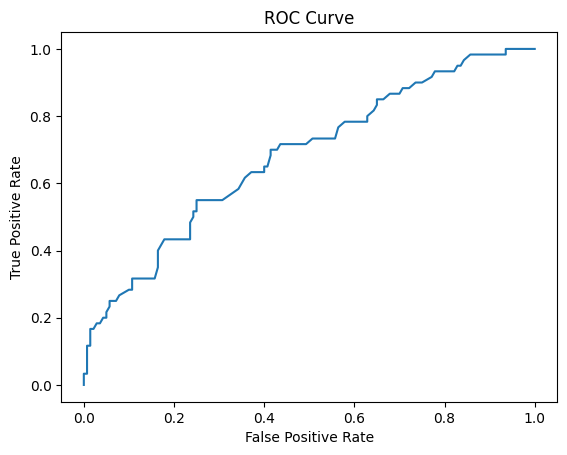

ROC AUC Score: 0.6807738095238096


In [5]:
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = roc_auc_score(y_test, y_probs)

plt.figure()
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

print("ROC AUC Score:", roc_auc)

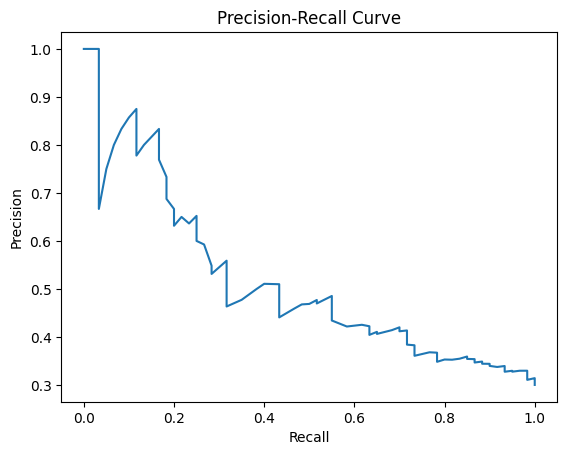

PR AUC Score: 0.5180926400694814


In [6]:
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_probs)
pr_auc = average_precision_score(y_test, y_probs)

plt.figure()
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

print("PR AUC Score:", pr_auc)

In [7]:
def business_cost(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    cost = (fp * 50000) + (fn * 5000)
    return cost

In [8]:
y_default = (y_probs >= 0.5).astype(int)

default_cost = business_cost(y_test, y_default)

print("Default Threshold Cost:", default_cost)
print(confusion_matrix(y_test, y_default))

Default Threshold Cost: 1255000
[[119  21]
 [ 41  19]]


In [9]:
thresholds = np.arange(0.1, 0.9, 0.05)
costs = []

for thresh in thresholds:
    y_pred_thresh = (y_probs >= thresh).astype(int)
    cost = business_cost(y_test, y_pred_thresh)
    costs.append(cost)

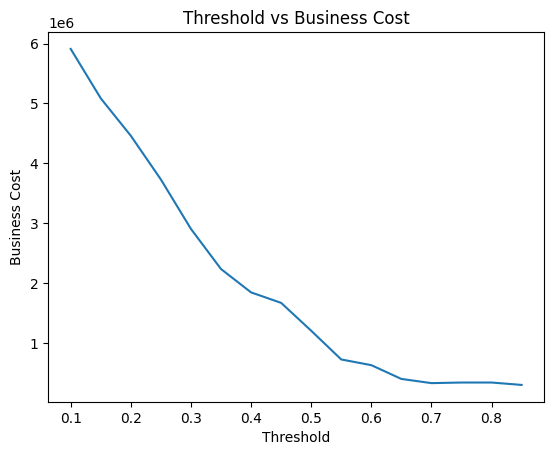

In [10]:
plt.figure()
plt.plot(thresholds, costs)
plt.xlabel("Threshold")
plt.ylabel("Business Cost")
plt.title("Threshold vs Business Cost")
plt.show()

In [11]:
optimal_index = np.argmin(costs)
optimal_threshold = thresholds[optimal_index]
optimal_cost = costs[optimal_index]

print("Optimal Threshold:", optimal_threshold)
print("Minimum Business Cost:", optimal_cost)

Optimal Threshold: 0.8500000000000002
Minimum Business Cost: 300000


In [12]:
y_optimal = (y_probs >= optimal_threshold).astype(int)

print("Confusion Matrix at Optimal Threshold:")
print(confusion_matrix(y_test, y_optimal))

print("\nClassification Report:")
print(classification_report(y_test, y_optimal))

Confusion Matrix at Optimal Threshold:
[[140   0]
 [ 60   0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.70      1.00      0.82       140
           1       0.00      0.00      0.00        60

    accuracy                           0.70       200
   macro avg       0.35      0.50      0.41       200
weighted avg       0.49      0.70      0.58       200



C:\Users\user\AppData\Roaming\Python\Python314\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\user\AppData\Roaming\Python\Python314\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\user\AppData\Roaming\Python\Python314\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

In [13]:
reduction_percent = ((default_cost - optimal_cost) / default_cost) * 100

print("Business Cost Reduced by: {:.2f}%".format(reduction_percent))

Business Cost Reduced by: 76.10%
